In [1]:
import csv
import re
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style, colors
import matplotlib.patches as patches
from matplotlib import gridspec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist


# matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to enable jupyter ipython widgets run following line at command line
# jupyter nbextension enable --py widgetsnbextension
# to import ipywidgets in jupyter notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


# constants

##### use this histology
final_histologyf = '/projects/trans_scratch/validations/workspace/szong/Cervical/histologic_diagnosis_118_20190108.txt'

In [2]:
amp_threshold = 1.2 # log2(1.5)
del_threshold = -0.8 # log2(0.5)
# amp_threshold = 0.1 # log2(1.5)
# del_threshold = -0.1 # log2(0.5)
# use this file for final histology
final_histologyf = '/projects/trans_scratch/validations/workspace/szong/Cervical/histologic_diagnosis_118_20190108.txt'
clinic_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/nationwidechildrens.org_clinical_patient_cesc.txt'
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/'
patients_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt'
colormap_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
# mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details.txt'
mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency.txt.20190104'
codingmut_rate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/coding_mutation_rate.txt.20190104'
# gatk_cnv = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_thresholded.by_genes.txt'
gatk_cnv = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_data_by_genes.txt'

# 1. functions

In [3]:
def plot_mutation_rate(ax, df, patients, clrmap_dict):
    ax.set_title("") 
    clrs = [clrmap_dict[m] for m in ['Non-synonymous', 'Synonymous']]
    df_mut_rate = df[['nsyno_mut_rate', 'syno_mut_rate']].reindex(patients)
    df_mut_rate.plot.bar(stacked=True, ax=ax, color=clrs, width=.8)
    ax.set_ylim(0,100)
    _ = ax.set_xticklabels(df_mut_rate.index.tolist(), fontsize=5)
    _ = ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=16)
    _ = ax.legend(labels=['Non-synonymous', 'Synonymous'], frameon=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)

In [4]:
def plot_mutation_type_count(ax, df, mut_colors):
    ax.set_title("")  
    df_type_count = df.drop(['HIV_status', 'Putative_histology'])
    df_type_count = df_type_count.T.apply(lambda x: x.value_counts()).T
    # insert 2 fake rows in the begining to line up the bars with genes
    df_type_count = pd.concat([pd.DataFrame([[np.nan]*6, [np.nan]*6], 
                                                     index=['HIV_status', 'Putative_histology'], 
                                                     columns=df_type_count.columns), 
                                                     df_type_count])
    df_type_count = df_type_count[mutations]
    df_type_count.plot(kind='barh',ax=ax, stacked=True, width=.8, color=mut_colors)
    plt.gca().invert_yaxis()
    ax.legend_.remove()
    ax.yaxis.set_ticks_position('left')
    adjust_spines(ax, ['top', 'right'])
    ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    ax.set_yticklabels('')
    ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=16, rotation=90)

In [5]:
def plot_gene_mutation_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    df = df.drop('mfreq', axis=1)
    df.loc['HIV_status', 'hiv_pos_mfreq'] = 0
    df.loc['HIV_status', 'hiv_neg_mfreq'] = 0
    df.loc['Putative_histology', 'hiv_pos_mfreq'] = 0
    df.loc['Putative_histology', 'hiv_neg_mfreq'] = 0
    yticklabels = ['']*len(df.index.tolist())
    yticklabels[0] = ''
    yticklabels[1] = ''
    # bar color consistent to heatmap
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    # hiv_cmap = colors.ListedColormap(hiv_colors)
    # make sure the color of mutation type consistent with the heatmap
    df = df[['hiv_{}_mfreq'.format(i.lower()[:3]) for i in HIV_status]]
    df.plot(kind='barh', ax=ax, stacked=False, width=1.0, color=hiv_colors)
    # _ = ax.set_xticklabels([''.join([str(i), '%']) for i in [0,10,20,30,40]], fontsize=20)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    # _ = ax.tick_params(axis='y', which='major', labelsize=20, pad=0) # add/reduce space between axis and its ticklables

    # _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.set_yticklabels(yticklabels, rotation=0, fontsize=16)
    adjust_spines(ax, ['top', 'right'])
    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
    ax.set_xticklabels([''.join([str(int(i)), '%']) for i in ax.get_xticks()], fontsize=16, rotation=0)
    # plt.show()
    # ax.get_xticks()

In [6]:
def plot_mutation_heatmap(ax, df, map_dict, cmap):
#     print('*******', df.head(2))
    df = df.apply(lambda x: x.map(map_dict)).astype(float)
#     print('>>>>>>>>', map_dict)
#     print('++++++++', df.head(2))
    sns.heatmap(df, 
                ax=ax, 
                cmap=cmap,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) #cbar_ax=ax1,
    _ = ax.tick_params(axis='y', which='major', labelsize=16)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    # _ = ax.set_yticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=True)
    _ = plt.setp(ax.get_xticklines(),visible=False)

In [7]:
def plot_covariate_track(ax, df, patients, map_dict_cov, cmap_cov):
    df = df[patients]
    df_mapped = df.apply(lambda x: x.map(map_dict_cov)).astype(float)
    print(df_mapped)
    sns.heatmap(df_mapped, 
                ax=ax, 
                cmap=cmap_cov,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) 
    _ = ax.tick_params(axis='y', which='major', labelsize=20)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)



In [8]:
def add_patches(ax, features, column, clrmap_dict):
    k = 0
    for feature in features:
        types = len(features)
        clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*.15, .9-k*0.1), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*.15, .9-k*0.1+.005, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')


In [9]:
def sort_patients(dfxx):
    # exhausitive binary sort
    i = 1e18
    arr = []
    for ix, row in dfxx.iterrows():
        arr.append(row * i)
#         print(i)
        i = i/10
    sorted_pats = pd.DataFrame(arr).sum().sort_values(ascending=False).index.tolist()
#     print(pd.DataFrame(arr).sum().sort_values(ascending=False))
    return sorted_pats

In [10]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    if 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [11]:
def plot_copy_number(df, amp_threshold, ax):
    for ix, row in df.iterrows():
        tmp = row.dropna()
        markers = ['^' if i>amp_threshold else 'v' for i in tmp ]
        colors = ['red' if i>amp_threshold else 'blue' for i in tmp ]
        for j, x in enumerate(tmp):
            _ = ax.scatter(tmp.index.tolist()[j]+.45, int(ix)+2.5, 
                           marker=markers[j],facecolor=colors[j], 
                           edgecolor='black', linewidth='0.5', s=30)

In [13]:
# outdated
def get_coords(df):
    '''
    get coordinates of cnvs, cnv matrix needs to be indexed the same as variants matrix
    df is copy number matrix    
    '''
    dftmp = df.reset_index(drop=True)
#     dftmp.head(2)

    dftmp.columns = [i for i in range(dftmp.shape[1])]
    
#     dftmp.head(2)
#     dfa.head()
    cnv_xs = []
    cnv_ys = []
    cn = []

    # get coordinates where there are copy number changes

    for row in dftmp.index: 
        for col in dftmp.columns:
#                 print(row, col)
            if (dftmp.at[row,col] > 0.58) or (dftmp.at[row, col] < -1):
                cn.append(dftmp.loc[row,col])
                cnv_xs.append(col)
                cnv_ys.append(row)

    #             print([row, col])
    dff = pd.DataFrame()
#     dff.at[row, col] = 
    return cnv_xs, cnv_ys
    
cnv_xs, cnv_ys = get_coords(cnvs)

NameError: name 'cnvs' is not defined

# patients in cohort

In [14]:
# 118 patients
# patients_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt'
with open(patients_f) as file:
    patients = [line.strip() for line in file]
assert len(patients) == 118
patients[:2]

['HTMCP-03-06-02001', 'HTMCP-03-06-02002']

# 2. color scheme

In [16]:
# choose color from here
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

,0,1
0,HPV16,#7F3B08
1,HPV31,#B35806


('HPV16', '#7F3B08')

37    Synonymous
38     Stage IB1
39     Stage IB2
40     Stage IIA
41    Stage IIA1
42    Stage IIA2
43     Stage IIB
44    Stage IIIA
45    Stage IIIB
46     Stage IVA
47     Stage IVB
48       Stage I
49      Stage II
50     Stage III
51      Stage IV
Name: 0, dtype: object

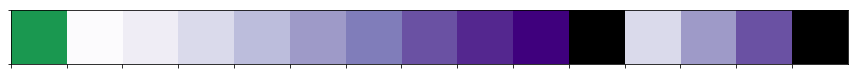

In [15]:
df_clrs = pd.read_csv(colormap_f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]

all_colors = [ "purple", "#E69F00",'pink', 'gray',"#009E73","#56B4E9","#377EB8",
        "#E41A1C","#F0E442",'black',"#D55E00","#CC79A7", "#D55E00","#CC79A7"]
sns.palplot(df_clrs[1][-15:])
df_clrs[0][-15:]

# 3. mutation input matrix

In [16]:
# mutation_f= '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency.txt'
df = pd.read_csv(mutation_f, index_col='gene')
# sort gene based on frequency
df = df.sort_values('mfreq', ascending=False)
df.head()

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,...,HTMCP-03-06-02326,HTMCP-03-06-02185,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02332,HTMCP-03-06-02156,HTMCP-03-06-02046,HTMCP-03-06-02008,HTMCP-03-06-02037
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
PIK3CA(35%),28,44,35,Non-synonymous,Non-synonymous,Multiple,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1(19%),16,22,19,Non-synonymous,Multiple,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2(15%),9,22,15,Multiple,NaN,Synonymous,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### fisher test to see if mutated genes enriched either in hiv+ or - cohort

In [42]:
def fisher(np, nn, npos, nneg):
    # npos number of hiv pos patients in the cohort
    # np number of hiv pos patients with at least one  mutation in hotspot
    oddsratio, p = stats.fisher_exact([[np, nn], [npos-np, nneg-nn]])
    return p
fisher(10,1, 73, 45)
def calculate_fisher_pvalue(df):
    df['fisher_pvalue'] = df[['pos', 'neg']]\
    .apply(lambda x: fisher(x['pos'], x['neg'], npos, nneg ),axis=1)

0.04963942373741622

In [53]:
pos_s = df[[i for i in df.columns if (i.startswith('HTMCP') and df.loc['HIV_status',i]=='Positive')]].notna().sum(axis=1)
neg_s = df[[i for i in df.columns if (i.startswith('HTMCP') and df.loc['HIV_status',i]=='Negative')]].notna().sum(axis=1)
mut_counts = pd.DataFrame([pos_s, neg_s]).T
mut_counts.columns = ['pos', 'neg']
mut_counts
npos = 73
nneg = 45
calculate_fisher_pvalue(mut_counts)
mut_counts

,pos,neg
gene,,
HIV_status,73,45
Putative_histology,73,45
PIK3CA(35%),21,20
FAT1(19%),12,10
MLL2(15%),7,10
FBXW7(10%),6,6
CASP8(7%),5,3
SLC35G5(7%),7,1
MAPK1(5%),4,2


,pos,neg,fisher_pvalue
gene,,,
HIV_status,73,45,1.000000
Putative_histology,73,45,1.000000
PIK3CA(35%),21,20,0.111175
FAT1(19%),12,10,0.471432
MLL2(15%),7,10,0.065438
FBXW7(10%),6,6,0.531927
CASP8(7%),5,3,1.000000
SLC35G5(7%),7,1,0.152690
MAPK1(5%),4,2,1.000000


In [44]:
# # select columns based on values in a row, use series selection or transpose the df first
# s = df.loc['Putative_histology',] == 'Adenosquamous'
# # s
# s[s]
# df[['HTMCP-03-06-02326', 'HTMCP-03-06-02267', 'HTMCP-03-06-02396', 'HTMCP-03-06-02442']]

In [17]:
# sort patients based on if a gene is mutated or not in the order of genes
dfx = df[[i for i in tqdm(df.columns) if i.startswith('HTMCP')]]
dfy = dfx.drop(['HIV_status','Putative_histology' ])
dfq = dfx.loc[['HIV_status','Putative_histology'],]
dfz = dfy.notnull()
dfxx = pd.concat([dfq, dfz]).drop('Putative_histology').replace('Positive', True).replace('Negative', False)
dfxx.head()

sorted_pats = sort_patients(dfxx)

sorted_patients = ['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq',] + sorted_pats
df = df[sorted_patients]

sorted_pats[:3]
df.head(3)

100%|██████████| 121/121 [00:00<00:00, 167274.48it/s]


,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02185,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02332,HTMCP-03-06-02156,HTMCP-03-06-02046,HTMCP-03-06-02008,HTMCP-03-06-02037
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
PIK3CA(35%),True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FAT1(19%),True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MLL2(15%),True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FBXW7(10%),False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


['HTMCP-03-06-02260', 'HTMCP-03-06-02428', 'HTMCP-03-06-02139']

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
PIK3CA(35%),28,44,35,Non-synonymous,Non-synonymous,Multiple,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. copy number input matrix

# 5. plotting

# 4. get coding mutation rate per mb

In [18]:
# codingmut_rate_f  = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/coding_mutation_rate.txt'
# df2.to_csv(of, sep='\t', index=False)
df2 = pd.read_csv(codingmut_rate_f, index_col='patient')
df2 = df2.loc[patients,]
df2.head(2)
df2.shape

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,...,patient_id,pregnancies_count_induced_abortion,pregnancies_count_miscarriage,tobacco_smoking_history_indicator,total_pregnancy_count,tumor_grade,weight_kg_at_diagnosis,syno_mut_rate,nsyno_mut_rate,total
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,25732,1242,329,11,102,0,26974,340,102,238,...,2001.0,NaN,1.0,1.0,6.0,G2,44.5,3.560476,8.307778,11.868255
HTMCP-03-06-02002,15964,697,225,2,72,0,16661,227,72,155,...,2002.0,3.0,NaN,1.0,11.0,G3,70.2,2.513277,5.410528,7.923805


(118, 48)

In [19]:
df2['total'].describe()

count    118.000000
mean       9.817342
std       11.915435
min        1.047199
25%        3.970629
50%        6.492633
75%        9.669137
max       84.055169
Name: total, dtype: float64

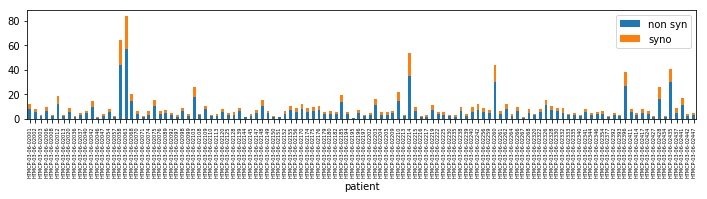

In [20]:
fig = plt.figure(facecolor='white',  figsize=(12,2))
ax = fig.add_subplot(111, facecolor='white')
df2[['nsyno_mut_rate', 'syno_mut_rate']].plot.bar(stacked=True, ax=ax)
# ax.set_ylim(0,100)
_ = ax.set_xticklabels(df2.index.tolist(), fontsize=5)
_ = ax.legend(labels=['non syn', 'syno'])

In [21]:
df_cov = (df2[['tumor_grade', 'age_at_diagnosis', 'clinical_stage']].T)[sorted_pats]

In [22]:
df_cov.notnull().sum(axis=1)

tumor_grade          88
age_at_diagnosis    114
clinical_stage      115
dtype: int64

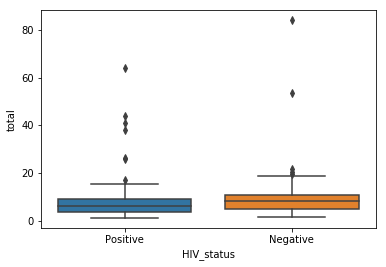

NameError: name 'ss' is not defined

In [23]:
# mutation rate and age significance between hiv+ and -
# feature =  'age_at_diagnosis'
# feature = 'strelka_mutations'
feature = 'total'

dftmp = df2[['HIV_status', feature]].dropna()

hiv_pos = dftmp.query('HIV_status=="{}"'.format('Positive'))[feature]
hiv_neg = dftmp.query('HIV_status=="{}"'.format('Negative'))[feature]

f, ax = plt.subplots()
_ = sns.boxplot('HIV_status', feature, data=dftmp, ax=ax)
plt.show()

sts, p = ss.mannwhitneyu(hiv_pos, hiv_neg, use_continuity=True, alternative=None)
p


In [24]:
ages = []
for n in df_cov.loc['age_at_diagnosis', ].tolist():
#     print(n)
    n = float(n)
    if n <= 45:
        gr = '<45'
    elif n>45 and n<=65:
        gr = '45-65'
    elif n > 65:
        gr = '>65'
    else:
        gr = 'unknown'
    ages.append(gr)
df_cov.loc['age_at_diagnosis', ] = ages

In [25]:
df_cov = df_cov.fillna('unknown')

In [26]:
df_cov.loc['clinical_stage',:] = df_cov.loc['clinical_stage',:].str.replace('[AB]\d*', '')

In [27]:
df_cov.loc['tumor_grade', ].unique()

array(['G2', 'unknown', 'G3', 'G1'], dtype=object)

In [28]:
df_cov.loc['age_at_diagnosis', ].unique()
df_cov.loc['clinical_stage', ].unique()

array(['<45', '45-65', 'unknown', '>65'], dtype=object)

array(['Stage I', 'Stage II', 'Stage IV', 'Stage III', 'unknown'],
      dtype=object)

### stage counts

In [51]:
df.head(5)

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
PIK3CA(35%),28,44,35,Non-synonymous,Non-synonymous,Multiple,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1(19%),16,22,19,Non-synonymous,Multiple,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2(15%),9,22,15,Multiple,NaN,Synonymous,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_stage = pd.concat([df_cov, df[[i for i in df.columns if i.startswith('HTMCP')]]], sort=False).loc[['HIV_status', 'clinical_stage'], :].T.reset_index()
df_stage[:2]

,patient,HIV_status,clinical_stage
0,HTMCP-03-06-02260,Positive,Stage I
1,HTMCP-03-06-02428,Positive,Stage II


In [51]:
df_stage = df_stage.pivot_table(index='HIV_status', columns='clinical_stage', values='patient', aggfunc='count').T
df_stage.columns = ['neg', 'pos']
df_stage

,neg,pos
clinical_stage,,
Stage I,2,16
Stage II,27,26
Stage III,13,25
Stage IV,2,4
unknown,1,2


In [54]:
calculate_fisher_pvalue(df_stage)
df_stage

,neg,pos,fisher_pvalue
clinical_stage,,,
Stage I,2,16,0.015646
Stage II,27,26,0.013169
Stage III,13,25,0.685398
Stage IV,2,4,1.000000
unknown,1,2,1.000000


In [266]:
df_cov

patient,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
tumor_grade,G2,unknown,G3,G3,unknown,G2,unknown,G3,G2,G2,...,G2,unknown,G1,G3,unknown,G2,G3,unknown,G3,G3
age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65
clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III


In [57]:
df2.head(2)

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,...,patient_id,pregnancies_count_induced_abortion,pregnancies_count_miscarriage,tobacco_smoking_history_indicator,total_pregnancy_count,tumor_grade,weight_kg_at_diagnosis,syno_mut_rate,nsyno_mut_rate,total
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,25732,1242,329,11,102,0,26974,340,102,238,...,2001.0,NaN,1.0,1.0,6.0,G2,44.5,3.560476,8.307778,11.868255
HTMCP-03-06-02002,15964,697,225,2,72,0,16661,227,72,155,...,2002.0,3.0,NaN,1.0,11.0,G3,70.2,2.513277,5.410528,7.923805


In [59]:
# # add mutation frequency into the gene label
# df.head(2)
# df = df.reset_index()
# df['xxxx'] = df.apply(lambda x: ''.join([str(x[0]), '(', str(x[3]), '%)']), axis=1)
# df.set_index('gene', inplace=True)
# df.loc['HIV_status', 'xxxx'] = 'HIV_status'
# df.loc['Putative_histology', 'xxxx' ] = 'Putative_histology'
# df = df.set_index('xxxx', drop=True)

# df.head(2)

# np.unique(df.values.ravel().astype(str))

# df.head(2)
# df.shape
# assert len(patients)+3==df.shape[1]

In [60]:
# # add mutation frequency into the gene label
# df.head(2)
# df = df.reset_index()
# df['gene'] = df.apply(lambda x: ''.join([str(x[0]), '(', str(x[3]), '%)']), axis=1)
# df.set_index('gene', inplace=True)
# df.loc['HIV_status', 'gene'] = 'HIV_status'
# df.loc['Putative_histology', 'gene' ] = 'Putative_histology'
# df = df.set_index('gene', drop=True)

# df.head(2)

# np.unique(df.values.ravel().astype(str))

# df.head(2)
# df.shape
# assert len(patients)+3==df.shape[1]

# copy number changes reported  by GATK CNVs

this is an important paper to reference when decide the thresholds for copy number amplification and deletion in the SMGs

https://www.pnas.org/content/suppl/2007/11/20/0710052104.DC1#F7

In [55]:
# get ordered smgs and patient
smgs = df.index.tolist()[2:]
smgs = [i.split('(')[0] for i in smgs]
smgs[:2]
patients = df.columns.tolist()[3:]
patients[:2]

['PIK3CA', 'FAT1']

['HTMCP-03-06-02260', 'HTMCP-03-06-02428']

In [56]:
smgs

['PIK3CA',
 'FAT1',
 'MLL2',
 'FBXW7',
 'CASP8',
 'SLC35G5',
 'MAPK1',
 'PCDHGA12',
 'PSPC1',
 'ZNF750',
 'PCDHA9',
 'ZC3H6']

In [37]:
cnvs = pd.read_csv(gatk_cnv, sep='\t', index_col='Gene Symbol')

In [38]:
# why these 2 patient has no copy results?
# not clear. confirmed both patients are in the segmentation file, but not in all_data_by_gene file
# both numbers make sense in hiv_pos and hiv_neg run, why not in 118_patient run
s = cnvs.isna().any()
s[s==True]

Series([], dtype: bool)

In [39]:
dftmp.shape

(118, 2)

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


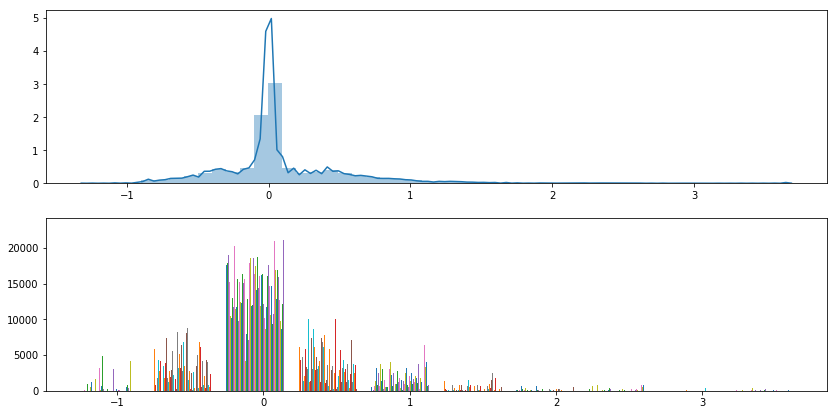

In [11]:
# cnvs.shape
# cnvs.head(2)
# log2 copy ratio distribution
cnvs = cnvs.loc[:, patients]
fig, axes = plt.subplots(2,1, figsize=(14,7))
# axes = .subplots(211)
dftmp = cnvs.dropna(axis=1)
_ = sns.distplot(dftmp.values.ravel(), kde=True, ax=axes[0])

_ = axes[1].hist(dftmp.values)

f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/gatk_copy_ratio_distribution_20190227.png'
plt.savefig(f, bbox_inches='tight', dpi=200)

In [40]:
cnvs = cnvs.loc[smgs, patients]
cnvs.fillna(0, inplace=True)
# cnvs.head(2)
# pd.Series(cnvs.values.ravel()).unique()

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [13]:
# figure out the correlation between copy number and expression
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/118_patient_rpkm.csv'
expr = pd.read_csv(f, index_col='gene')
expr.shape
expr.head(2)

(51595, 118)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447
gene,,,,,,,,,,,,,,,,,,,,,
10_PPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12_FKBP10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cnvs.max().max()
cnvs.min().min()

3.657

-1.2930000000000001

In [15]:
# merge the mutation status
adf = df[[i for i in df.columns if i.startswith('HTMCP')]].reset_index()
adf['gene_new'] = adf.gene.apply(lambda x: x.split('(')[0])
adf.drop('gene', axis=1, inplace=True)
adf.set_index('gene_new', inplace=True)

adf.head(2)

bdf = adf.notna()
bdf.head(2)
bdf = bdf.loc[smgs, patients]
bdf.head(2)

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02185,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02332,HTMCP-03-06-02156,HTMCP-03-06-02046,HTMCP-03-06-02008,HTMCP-03-06-02037
gene_new,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous


,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02185,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02332,HTMCP-03-06-02156,HTMCP-03-06-02046,HTMCP-03-06-02008,HTMCP-03-06-02037
gene_new,,,,,,,,,,,,,,,,,,,,,
HIV_status,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Putative_histology,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02185,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02332,HTMCP-03-06-02156,HTMCP-03-06-02046,HTMCP-03-06-02008,HTMCP-03-06-02037
gene_new,,,,,,,,,,,,,,,,,,,,,
PIK3CA,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FAT1,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [221]:
bdf

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
gene_new,,,,,,,,,,,,,,,,,,,,,
PIK3CA,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FAT1,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MLL2,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FBXW7,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CASP8,True,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SLC35G5,True,False,True,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
MAPK1,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
PCDHGA12,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
PSPC1,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [16]:
@interact
def plot_expr_cnv(gene=smgs):
    a = expr.loc[[gene],patients]
    b = cnvs.loc[[gene],patients]
    d = bdf.loc[[gene], patients]
    c = pd.concat([a, b, d]).T
    c.columns =['rpkm', 'log2cn', 'muts']
    _ = sns.lmplot('log2cn', 'rpkm', data=c, hue='muts') 
    _ = plt.axvline(1.2, 0, 1, c='red')
    _ = plt.axvline(-0.8, 0, 1, c='blue')
    _ = plt.xlim(cnvs.min().min()-0.1, cnvs.max().max()+0.1)
    _ = plt.ylim(0, c['rpkm'].max()+0.1)
    _ = plt.title(gene)
    plt.savefig(f'{gene}.rpkm.cnvs.png', bbox_inches='tight', dpi=200)

    plt.show()

interactive(children=(Dropdown(description='gene', options=('PIK3CA', 'FAT1', 'MLL2', 'FBXW7', 'CASP8', 'SLC35…

In [225]:
85/(85+890)

0.08717948717948718

NameError: name 'cnv_xs' is not defined

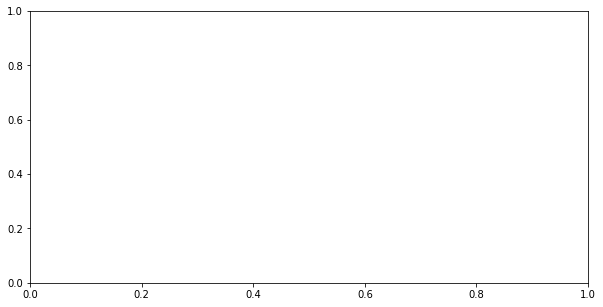

In [63]:
# why almost all patients have copy changes
f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(cnv_xs, cnv_ys)
# dff = pd.DataFrame(cn, index=cnv_xs, columns=cnv_ys)
# dff
# sns.regplot(cnv_xs, cnv_ys)
plt.show()

In [106]:
# re.search?
re.search("[a-zA-Z]\d{2}", "S07E01 - Meet the New Boss.avi")

<_sre.SRE_Match object; span=(0, 3), match='S07'>

In [117]:
# simplify stages
# p = r'[ab]'
# re.search(p, 'a')
p = '[ABCat]' # match A or B or C or a or t
p = '(B|Cat|a)' # match A or B or Cat
p = '[AB]\d*'
re.search(p, 'IIA')
# df_cov.loc['clinical_stage',:]



<_sre.SRE_Match object; span=(2, 3), match='A'>

In [124]:
df_cov

patient,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
tumor_grade,G2,unknown,G3,G3,unknown,G2,unknown,G3,G2,G2,...,G2,unknown,G1,G3,unknown,G2,G3,unknown,G3,G3
age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65
clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III


['Adeno', 'Squamous', 'Neuroendocrine', 'Adenosquamous', 'Negative', 'Positive', 'Non-synonymous', 'Frameshift', 'Stop gained', 'Start gained', 'Synonymous', 'Multiple']
####### {'HPV16': '#7F3B08', 'HPV31': '#B35806', 'HPV33': '#E08214', 'HPV35': '#FDB863', 'HPV52': '#FEE0B6', 'HPV58': '#F7F7F7', 'HPV18': '#2D004B', 'HPV45': '#542788', 'HPV68': '#8073AC', 'HPV59': '#B2ABD2', 'HPV82': '#252525', 'HPV51': '#525252', 'HPV9': '#737373', 'HPV69': '#969696', 'HPV30': '#BDBDBD', 'HPV26': '#D9D9D9', 'Positive': '#018571', 'Negative': '#80cdc1', 'Squamous': '#d73027', 'Neuroendocrine': '#e0f3f8', 'Adenosquamous': '#91bfdb', 'Adeno': '#4575b4', 'Mutated': 'black', 'Wild Type': '#f5f5f5', nan: 'white', 'G1': '#d1e5f0', 'G2': '#67a9cf', 'G3': '#2166ac', 'unknown': 'white', '<45': '#e5f5e0', '45-65': '#a1d99b', '>65': '#31a354', 'Frameshift': '#fc8d59', 'Multiple': '#fee090', 'Non-synonymous': '#3288bd', 'Start gained': '#d1e5f0', 'Stop gained': '#d73027', 'Synonymous': '#1a9850', 'Stage IB1': '#f

NameError: name 'cnvs' is not defined

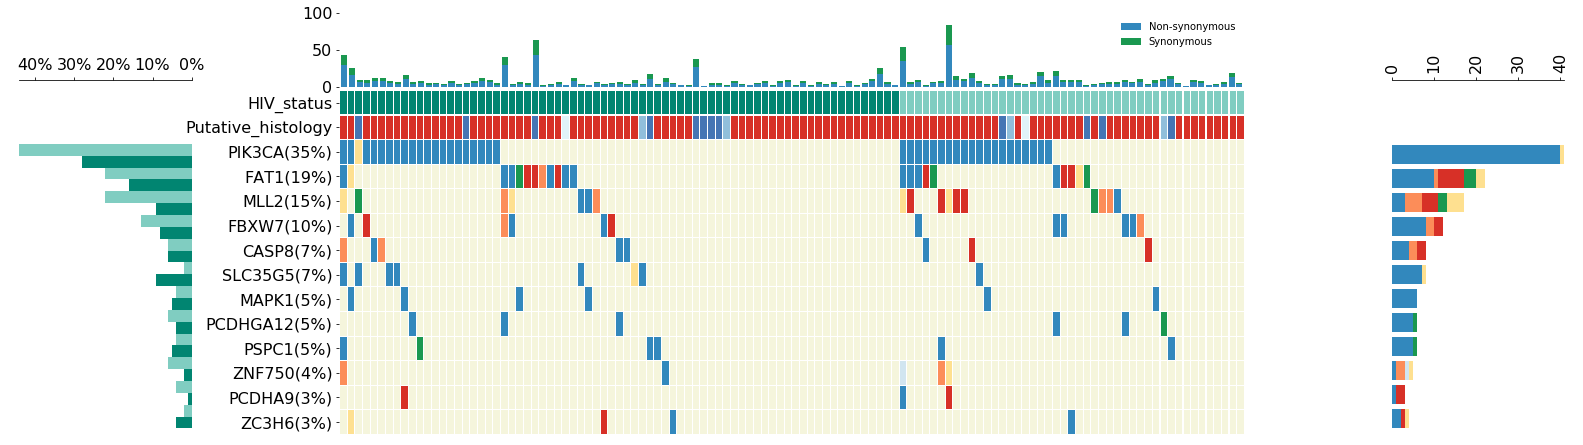

In [57]:
# to reduce blank space for specific subplots not all, reference to this link
# https://stackoverflow.com/questions/31484273/spacing-between-some-subplots-but-not-all
# df2: mutation rate
# df: mutation matrix
# patients: ordered columns
    
nrows = df.shape[0]    
fig = plt.figure(figsize=(28,.95*nrows), facecolor='white')
gs = gridspec.GridSpec(4, 3,                            
                       width_ratios=[3,15,3], 
                       height_ratios=[3,14,3,9],
                       wspace=0.35, # horizontal space
                       hspace=0.02  # vertical space
                      )
# grid 0  1  2  3
#      4  5  6  7
#      8  9  10 11
all_colors = [ "purple", "#E69F00",'pink', 'gray',"#009E73","#56B4E9","#377EB8",
        "#E41A1C","#F0E442",'black',"#D55E00","#CC79A7", "#D55E00","#CC79A7"]
patients = [p for p in df.columns.tolist() if p.startswith('HTMCP')]
# dfa plot the heatmap of different types of mutations
histology = ['Adeno', 'Squamous', 'Neuroendocrine', 'Adenosquamous']
HIV_status = ['Negative', 'Positive']
mutations = ['Non-synonymous', 
#              'Codon indel', 
             'Frameshift',              
#              'Splice site', 
             'Stop gained',
             'Start gained',
             'Synonymous',
             'Multiple']
# covariates = ['G1', 'G2', 'G3', '<45', '45-65', '>65', 'unknown']
tumor_grades = ['G1', 'G2', 'G3','unknown']
stages = ['Stage I',  'Stage II', 'Stage III', 'Stage IV', 'unknown']
ages = ['<45', '45-65', '>65', 'unknown']
covariates = tumor_grades[:-1] + ages[:-1] + stages

# make mapdict/clrmap_dict for mutation heatmap
categories = histology + HIV_status + mutations
print(categories)

# make map dictionary
map_dict = {k:v for v, k in  enumerate(categories)} 
# clrs = all_colors[:len(map_dict)]    
# clrmap_dict = {k:v for k, v in zip(map_dict.keys(), clrs)}
clrmap_dict = color_dict
print('#######', clrmap_dict)
types = len(map_dict)
clrs = [clrmap_dict[i] for i in categories]
cmap = colors.ListedColormap(clrs)
mut_colors = [clrmap_dict[m] for m in mutations]

b_lst = ['mfreq', 'hiv_pos_mfreq', 'hiv_neg_mfreq']
d_lst = ['tumor_grade']
e_lst = ['age_at_diagnosis']
g_lst = ['clinical_stage']
dfa = df.drop(b_lst, axis=1)

# dfb for unstacked barplot of mutation rate in hiv+ and - and full cohort
dfb = df[b_lst].astype(float)

# # mapdict/clrmap_dict for annotation
# map_dict_anno = {k:v for v, k in  enumerate(annotations)} 
# clrs_anno = [clrmap_dict[i] for i in annotations]    
# clrmap_dict_anno = {k:v for k, v in zip(map_dict_anno.keys(), clrs_anno)}
# types_anno = len(map_dict_anno)
# cmap_anno = colors.ListedColormap(clrs_anno)


# mapdict/clrmap_dict for covariates
map_dict_cov = {k:v for v, k in  enumerate(covariates)} 
clrs_cov = [clrmap_dict[i] for i in covariates]    
clrmap_dict_cov = {k:v for k, v in zip(map_dict_cov.keys(), clrs_cov)}
types_cov = len(map_dict_cov)
cmap_cov = colors.ListedColormap(clrs_cov)


# # plot coding mutation per mb mutation rate 
gs1 = gs[1]
ax1 = plt.subplot(gs1, facecolor='white', frameon=False)
plot_mutation_rate(ax1, df2, patients, clrmap_dict)


# plot mutation type count per gene
gs5 = gs[5]
ax5 = plt.subplot(gs5, facecolor='white', frameon=True)
plot_mutation_type_count(ax5, dfa, mut_colors)

# dfa = dfa.apply(lambda x: x.map(map_dict)).astype(float)
# plot mutation rate in hiv+ and - group, grouped barplot
gs3 = gs[3]
ax3 = plt.subplot(gs3, facecolor='white')
plot_gene_mutation_rate_group(ax3, dfb, HIV_status, clrmap_dict)


# plot heatmap for gene mutations
gs4 = gs[4]
ax4 = plt.subplot(gs4, facecolor='beige')
plot_mutation_heatmap(ax4, dfa, map_dict, cmap)

# add in copy number changes to mutation heatmap
# ax4.scatter(cnv_xs, cnv_ys)
cnvs_thresholded = cnvs[(cnvs>amp_threshold)|(cnvs<del_threshold)]
cnvs_thresholded = cnvs_thresholded.reset_index(drop=True)
cnvs_thresholded.columns = [i for i in range(cnvs_thresholded.shape[1])]
plot_copy_number(cnvs_thresholded, amp_threshold, ax4)

# add in covariate track including age and tumour grade
gs7 = gs[7]
ax7 = plt.subplot(gs7, facecolor='white')
plot_covariate_track(ax7, df_cov, patients, map_dict_cov, cmap_cov)

# map_dict_cov


# plot all legend
gs10 = gs[10]
ax10 =  plt.subplot(gs10, frameon=False)
_ = add_patches(ax10, histology, 0, clrmap_dict)
_ = add_patches(ax10, HIV_status, 1, clrmap_dict)
_ = add_patches(ax10, mutations, 2, clrmap_dict)
_ = add_patches(ax10, tumor_grades, 3, clrmap_dict)
_ = add_patches(ax10, ages, 4, clrmap_dict)
_ = add_patches(ax10, stages, 5, clrmap_dict)


# a few checks
# patient order consistent between dfa and df_type_count_per_patient
# assert (dfa.columns == df_type_count_per_patient.index).all()
# assert (dfa.columns == df_mut_rate.index).all()
# assert (dfa.columns == df_cov.columns).all()
# assert (df_type_count_per_patient.columns == df_type_count_per_gene.columns).all()
# gene order consistent among dfb, df_type_count_per_gene, and dfa
# assert (dfa.index ==  dfb.index).all()
# assert (dfa.index == df_type_count_per_gene.index ).all
# color scheme consistent between type count plot and heatmap and mutation rate plot
# print('map_dict is: {}'.format(map_dict))
# print('colors are: {}'.format(clrs))
# sns.palplot(clrs)

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/smgs_cnvs_oncoprint_20190227.png'
# %time plt.savefig(of, bbox_inches='tight',dpi=300)
plt.show()

reference paper: https://www.sciencedirect.com/science/article/pii/S1535610819300960#fig1

definition of gain, amplification, loss, and deletion:

(C) Known cancer-related genes located in significant GISTIC peaks with residual q < 1 × 10−4 (amplification, gain, neutral, loss, and deletion were defined as GISTIC +2, +1, 0, −1, and −2, respectively).

(A–C) Asterisks indicate associations with mRNA subtypes (intrinsic subtype, ASCAT ploidy, lymph node status, and somatic copy-number alterations were tested using Pearson's chi-square test; ASCAT purity and homologous recombination deficiency [HRD] score were tested using the Kruskal-Wallis test; age at surgery was tested using analysis of variance; apocrine differentiation and somatic mutations were tested using Fisher's exact test. ∗∗p < 0.01, ∗p < 0.05).

To assess somatic copy number alterations (CNAs), reported oncogenes and tumor suppressor genes observed in the top rank (residual q < 1 × 10−4) GISTIC peaks were examined 

 GISTIC2.0 was run with the following parameters changed from the default settings (-ta 0.2 -td 0.2 -genegistic 1 -smallmem 1 -broad 1 -conf 0.95 -rx 0 –brlen 0.7 -cap 3.5 –armpeel 1).
 
 

In [58]:
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_thresholded.by_genes.txt'
df = pd.read_csv(f, sep='\t')
df.drop(['Locus ID', 'Cytoband'], axis=1, inplace=True)
df = df[df['Gene Symbol'].isin(smgs)].set_index('Gene Symbol')
df = df.loc[smgs, :]
df.head()

,HTMCP-03-06-02256,HTMCP-03-06-02332,HTMCP-03-06-02414,HTMCP-03-06-02435,HTMCP-03-06-02261,HTMCP-03-06-02175,HTMCP-03-06-02098,HTMCP-03-06-02216,HTMCP-03-06-02155,HTMCP-03-06-02057,...,HTMCP-03-06-02148,HTMCP-03-06-02176,HTMCP-03-06-02174,HTMCP-03-06-02239,HTMCP-03-06-02354,HTMCP-03-06-02259,HTMCP-03-06-02180,HTMCP-03-06-02213,HTMCP-03-06-02179,HTMCP-03-06-02001
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
PIK3CA,1,1,0,1,1,1,0,0,0,1,...,1,1,1,1,1,0,1,1,1,2
FAT1,0,0,-1,-1,1,-1,-1,-1,0,0,...,0,-1,0,-2,-1,-1,-1,-1,-1,0
MLL2,0,0,-1,-1,1,1,0,-1,0,0,...,0,0,0,0,0,1,0,0,0,0
FBXW7,0,0,-1,-1,0,-1,-1,-1,0,0,...,0,0,0,-1,-1,-1,-1,1,-1,0
CASP8,0,0,1,0,1,0,0,0,0,0,...,-1,-1,1,1,-1,1,0,-1,0,-1


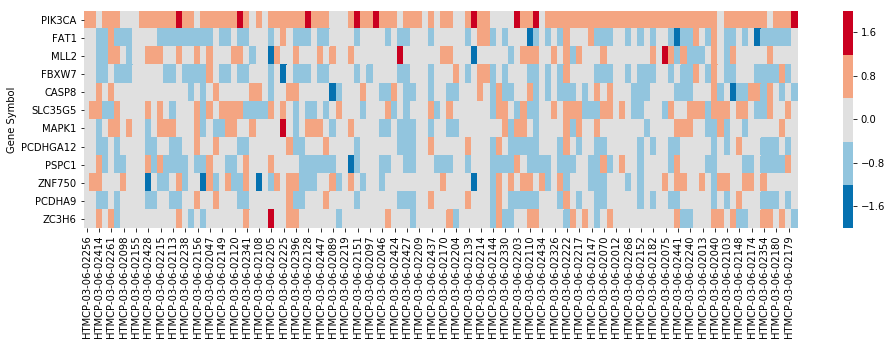

In [59]:
fig = plt.figure(figsize= (16, 4))
ax = fig.add_subplot(111)
# sns.heatmap(df, ax=ax, cmap=sns.diverging_palette(240, 10, sep=80,  n=5, center="light"))
# http://colorbrewer2.org/#type=diverging&scheme=RdGy&n=10
cmap = ['#08519c',  "#bdd7e7", "white", "pink","red" ]
cmap = ['#0571b0', '#92c5de','#e0e0e0', '#f4a582', '#ca0020']
sns.heatmap(df, ax=ax, cmap=cmap)

In [317]:
cnvs[:2]

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
PIK3CA,1.132,1.418,2.358,0.910,0.460,2.370,0.633,0.517,2.189,0.032,...,0.728,2.188,0.843,-0.007,1.123,-0.011,0.655,2.448,0.170,3.335
FAT1,-0.023,-0.057,-0.739,-0.161,-0.192,0.012,-0.547,-0.422,-0.032,-0.055,...,-0.036,0.000,0.038,-0.465,-0.027,-0.022,-0.061,0.310,-0.202,-0.022


### correlation between gatk cnvs and cnaseq(our inhouse cnv pipeline)

In [18]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/copy_number_gene_level.txt'
dftmp1 = pd.read_csv(f, sep='\t')
dftmp1.head()

,Ensembl_ID,Gene_Name,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,...,amp_count_hiv_pos,amp_fraction_hiv_pos,amp_count_hiv_neg,amp_fraction_hiv_neg,del_count_hiv_pos,del_fraction_hiv_pos,del_count_hiv_neg,del_fraction_hiv_neg,amp_fisher_pvalue,del_fisher_pvalue
0,ENSG00000000419,DPM1,2,2,2,2,1,2,4,2,...,32,0.438356,20,0.444444,1,0.013699,2,0.044444,1.000000,0.556939
1,ENSG00000000457,SCYL3,2,3,3,3,2,3,4,3,...,23,0.315068,28,0.622222,1,0.013699,0,0.000000,0.001258,1.000000
2,ENSG00000000460,C1orf112,2,3,3,4,2,3,4,3,...,20,0.273973,27,0.600000,1,0.013699,0,0.000000,0.000884,1.000000
3,ENSG00000000938,FGR,4,2,2,2,2,3,2,2,...,13,0.178082,8,0.177778,4,0.054795,0,0.000000,1.000000,0.296240
4,ENSG00000000971,CFH,2,3,3,3,2,3,4,3,...,23,0.315068,21,0.466667,1,0.013699,0,0.000000,0.118479,1.000000


In [19]:
dftmp2 = dftmp1.loc[dftmp1.Gene_Name.isin(smgs), ['Gene_Name']+patients].set_index('Gene_Name')

In [20]:
(dftmp2 != 2).sum(axis=1)
dftmp2 = dftmp2.reindex(smgs)

Gene_Name
CASP8       26
FAT1        36
MAPK1       24
FBXW7       33
PSPC1       34
PIK3CA      80
ZNF750      27
MLL2        17
SLC35G5     37
ZC3H6       11
PCDHA9      21
PCDHGA12    21
dtype: int64

In [21]:
dftmp2.head(2)

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02185,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02332,HTMCP-03-06-02156,HTMCP-03-06-02046,HTMCP-03-06-02008,HTMCP-03-06-02037
Gene_Name,,,,,,,,,,,,,,,,,,,,,
PIK3CA,3.0,4.0,4,3,2.0,5,3.0,3,4,2.0,...,2.0,2,4.0,3.0,4,4.0,2,3,2,5
FAT1,2.0,2.0,1,2,2.0,2,1.0,1,2,2.0,...,2.0,2,2.0,2.0,2,2.0,1,2,2,2


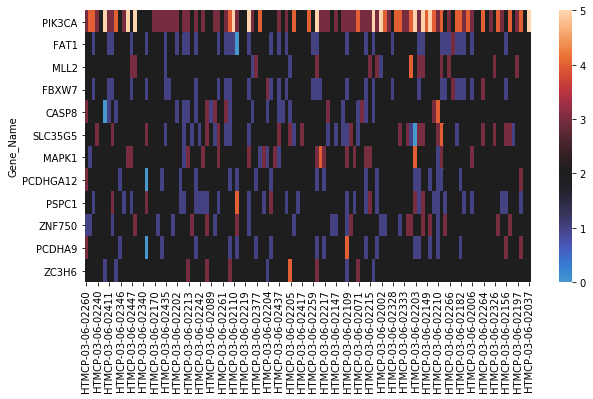

In [229]:
# why almost all patients have copy changes
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(dftmp2, center=2)
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/smgs_cnv_cnvseq.png'
plt.savefig(of, bbox_inches='tight',dpi=100)
plt.show()

In [22]:
@interact
def plot_gatk_cnaseq_cnv(gene=smgs):
    b = dftmp2.loc[[gene],patients]
    a = cnvs.loc[[gene],patients]
    c = pd.concat([a, b]).T
    c.columns =['log2cn', 'abs_cn']
    _ = sns.lmplot('log2cn', 'abs_cn', data=c) 
    _ = plt.axvline(1.2, 0, 1, c='red')
    _ = plt.axvline(-0.8, 0, 1, c='blue')
    _ = plt.xlim(cnvs.min().min()-0.1, cnvs.max().max()+0.1)
    _ = plt.ylim(0, c['abs_cn'].max()+0.1)
    _ = plt.title(gene)
    plt.savefig(f'{gene}gatck.vs.cnaseq.cnvs.png', bbox_inches='tight', dpi=200)

    plt.show()

interactive(children=(Dropdown(description='gene', options=('PIK3CA', 'FAT1', 'MLL2', 'FBXW7', 'CASP8', 'SLC35…

In [341]:
from tqdm import tqdm
for i in tqdm(range(10000)):
#     if i%99 == 5:
        print(i)

 10%|█         | 1018/10000 [00:00<00:01, 8866.64it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 25%|██▌       | 2513/10000 [00:00<00:01, 6942.85it/s]

1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715


 35%|███▌      | 3511/10000 [00:00<00:00, 6797.40it/s]

3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210


 55%|█████▌    | 5506/10000 [00:00<00:00, 6799.58it/s]


4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708

 65%|██████▌   | 6504/10000 [00:00<00:00, 6849.02it/s]

6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203


 85%|████████▍ | 8499/10000 [00:01<00:00, 6976.87it/s]


7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701

100%|██████████| 10000/10000 [00:01<00:00, 6884.15it/s]

8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196


classfication problem can be seen as find a line (in 2 dimensions) or a hyperplane (in multidimension space) to separate data points into different classes. You will need to adjust all the weights(W) and bias (b) to move the line/plane closer to misclassified points.
in 2 dimension, below defines the line
w1.x1 + w2.x2 + b = 0 or to be concise: WX + b = 0
y is the label 0 or 1, 1 means correctly classified.
In high dimension space, the formula becomes:
w1.x1 + w2.x2 + ... + wn. xn + b = 0, again the concise form is WX + b = 0

W = [w1, w2, ... Wn], W's shape is (1, n)

X = [x1, x2, ... xn], X's shape is (n, 1)

prediction's shape is (1,1).




(-10, 10)

(-10, 10)

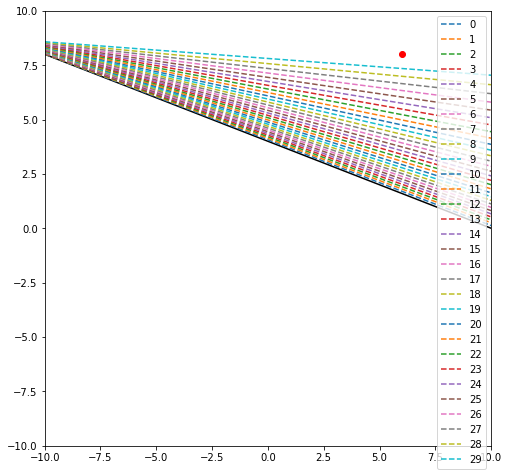

In [300]:
# illustration of weight changes move line closer to misclassifed point
w1 = 2
w2 = 5
b = -20
lr = .01

f, ax = plt.subplots(figsize=(8,8))
plt.xlim(-10,10)
plt.ylim(-10,10)


xs = np.array(ax.get_xlim())
ys = -(w1 * xs + b)/w2
_ = ax.scatter(6,8, c='red')
_ = ax.plot(xs, ys, c='black')

for p in range(30):

    w1 -= lr * 6
    w2 -= lr * 8
    b -= lr * 1

    xs = np.array(ax.get_xlim())
    ys = -(w1 * xs + b)/w2
    _ = ax.plot(xs, ys, '--', label=p)
plt.legend()    
plt.show()

In [ ]:
below are some preprocessing code:

In [30]:
# add mutation frequency into the gene label
df.head(2)
df = df.reset_index()
df['xxxx'] = df.apply(lambda x: ''.join([str(x[0]), '(', str(x[3]), '%)']), axis=1)
df.set_index('gene', inplace=True)
df.loc['HIV_status', 'xxxx'] = 'HIV_status'
df.loc['Putative_histology', 'xxxx' ] = 'Putative_histology'
df = df.set_index('xxxx', drop=True)

df.head(2)

np.unique(df.values.ravel().astype(str))

df.head(2)
df.shape
assert len(patients)+3==df.shape[1]

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
gene,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous


In [242]:
clidf = pd.read_csv(clinic_f, sep='\t')
clidf.head()

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,retrospective_collection,prospective_collection,birth_days_to,race,gender,menopause_status,height_cm_at_diagnosis,...,days_to_last_known_alive,days_to_sample_procurement,disease_code,icd_10,icd_o_3_histology,icd_o_3_site,informed_consent_verified,patient_id,project_code,tissue_source_site
0,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,tissue_retrospective_collection_indicator,tissue_prospective_collection_indicator,days_to_birth,race,gender,menopause_status,height,...,days_to_last_known_alive,days_to_sample_procurement,disease_code,icd_10,icd_o_3_histology,icd_o_3_site,informed_consent_verified,patient_id,project_code,tissue_source_site
1,CDE_ID:,CDE_ID:2003301,CDE_ID:,CDE_ID:3088528,CDE_ID:3088492,CDE_ID:3008233,CDE_ID:2192199,CDE_ID:2200604,CDE_ID:2957270,CDE_ID:649,...,CDE_ID:3131740,CDE_ID:3288495,CDE_ID:,CDE_ID:3226287,CDE_ID:3226275,CDE_ID:3226281,CDE_ID:3288361,CDE_ID:,CDE_ID:,CDE_ID:
2,444E50C8-C876-4D98-94A6-0A3474E2964B,HTMCP-03-06-02001,2016-2-12,NO,YES,[Not Available],BLACK OR AFRICAN AMERICAN,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,158.0,...,0,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],YES,02001,[Not Available],06
3,1E44A343-B770-4C6F-8EE0-7141A38558F6,HTMCP-03-06-02002,2016-2-12,NO,YES,-22934,BLACK OR AFRICAN AMERICAN,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,159.0,...,0,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],YES,02002,[Not Available],06
4,226914C5-E486-4041-9B0A-83BA8BAAE0E7,HTMCP-03-06-02003,2016-2-12,NO,YES,[Not Available],BLACK OR AFRICAN AMERICAN,FEMALE,Pre (<6 months since LMP AND no prior bilatera...,152.0,...,0,[Not Available],[Not Available],[Not Available],[Not Available],[Not Available],YES,02003,[Not Available],06


In [257]:
tf = clidf[['bcr_patient_barcode', 'histologic_diagnosis', 'hiv_status']]
tf[tf['bcr_patient_barcode'].isin(['HTMCP-03-06-02326', 'HTMCP-03-06-02267', 'HTMCP-03-06-02396', 'HTMCP-03-06-02442'])]
tf.to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/histologic_diagnosis.txt', sep='\t', index=False)

,bcr_patient_barcode,histologic_diagnosis,hiv_status
129,HTMCP-03-06-02267,Squamous Cell Carcinoma; Non-Keratinizing,Positive
134,HTMCP-03-06-02326,Squamous Cell Carcinoma; Non-Keratinizing,Negative
180,HTMCP-03-06-02396,Squamous Cell Carcinoma; Non-Keratinizing,Positive
207,HTMCP-03-06-02442,Squamous Cell Carcinoma; Non-Keratinizing,Positive


In [254]:
[c for c in clidf.columns if 'his' in c]

['history_other_malignancy',
 'history_hormonal_contraceptives_use',
 'history_neoadjuvant_treatment',
 'tobacco_smoking_history_indicator',
 'histologic_diagnosis',
 'history_immunological_disease',
 'history_immunological_disease_other',
 'history_immunosuppresive_rx',
 'history_immunosuppressive_rx_other',
 'history_relevant_infectious_dx',
 'history_immunosuppresive_dx_other',
 'histologic_diagnosis_other',
 'icd_o_3_histology']

In [244]:
for c in clidf.columns:
    print(c)

bcr_patient_uuid
bcr_patient_barcode
form_completion_date
retrospective_collection
prospective_collection
birth_days_to
race
gender
menopause_status
height_cm_at_diagnosis
weight_kg_at_diagnosis
live_birth_pregnancy_count
ethnicity
pregnancies_count_miscarriage
history_other_malignancy
pregnancies_count_ectopic
pregnancies_count_stillbirth
total_pregnancy_count
pregnant_at_diagnosis
vital_status
last_contact_days_to
death_days_to
cause_of_death
cause_of_death_other
history_hormonal_contraceptives_use
history_neoadjuvant_treatment
pregnancies_count_induced_abortion
tumor_status
karnofsky_score
treatment_outcome_first_course
radiation_treatment_adjuvant
tobacco_smoking_history_indicator
tobacco_smoking_year_stopped
tobacco_smoking_age_started
tobacco_smoking_pack_years_smoked
ecog_score
hiv_status
year_of_hiv_diagnosis
nadir_cd4_counts
cd4_counts_at_diagnosis
hiv_rna_load_at_diagnosis
prior_aids_conditions
hbv_test_results
histologic_diagnosis
hcv_test_results
keratinization_squamous_cel